# This notebook explores the annual number of hot days, hot spells and heatwaves in UKCP data 

## Hot days: Data

In [1]:
import iris

In [2]:
fname = "data/UKCP/tasmax_regional/tasmax_rcp85_land-cpm_uk_region_*.nc"
cubes = iris.load(fname, iris.Constraint(Region="London"))
iris.util.equalise_attributes(cubes)

In [3]:
tasmax, = cubes.concatenate()
tasmax.summary(shorten=True)

'air_temperature / (degC)            (ensemble_member: 3; time: 21600)'

In [4]:
tasmax_hot = tasmax.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>=25)
tasmax_hot.rename("Annual Hot Days (Daytime)")

In [5]:
fname = "data/UKCP/tasmin_regional/tasmin_rcp85_land-cpm_uk_region_*.nc"
cubes = iris.load(fname, iris.Constraint(Region="London"))
iris.util.equalise_attributes(cubes)

In [6]:
tasmin, = cubes.concatenate()
tasmin.summary(shorten=True)

'air_temperature / (degC)            (ensemble_member: 3; time: 21600)'

In [7]:
tasmin_hot = tasmin.aggregated_by("year", iris.analysis.COUNT, function=lambda value: value>=25)
tasmin_hot.rename("Annual Hot Days (Nighttime)")

## Hot days: Plotting

In [8]:
import iris.quickplot as qplt
import iris.plot as iplt
import matplotlib.pyplot as plt

In [9]:
def plot_ensemble(cube, dim_name="ensemble_member"):
    es, = cube.coord(dim_name).shape
    for i in range(0, es):
        qplt.plot(cube[i], 'o', alpha=0.2)

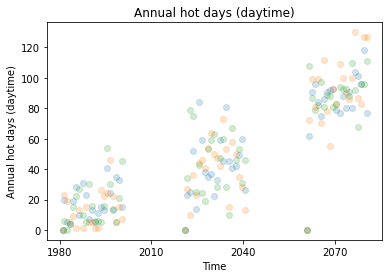

In [10]:
plot_ensemble(tasmax_hot)

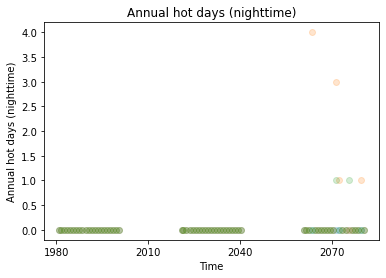

In [11]:
plot_ensemble(tasmin_hot)

## Hot day frequency counts

In [12]:
import xarray as xr
import numpy as np
import dask.array as da
import pandas as pd

In [13]:
tasx = xr.DataArray.from_iris(tasmax)

In [14]:
lon = tasx[0].compute()
lon

<xarray.DataArray 'tasmax' (time: 21600)>
array([ 7.1695294,  5.3445477,  3.2567596, ..., 10.356395 , 15.243307 ,
       11.799271 ], dtype=float32)
Coordinates:
    ensemble_member     int32 1
  * time                (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:0...
    geo_region          <U6 'London'
    region              int64 4
    ensemble_member_id  <U27 'HadREM3-RA11M-r001i1p00000'
    month_number        (time) int32 12 12 12 12 12 12 12 ... 11 11 11 11 11 11
    year                (time) int32 1980 1980 1980 1980 ... 2080 2080 2080 2080
    yyyymmdd            (time) <U64 '19801201' '19801202' ... '20801130'
Attributes:
    standard_name:   air_temperature
    long_name:       Maximum air temperature
    units:           degC
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    institution_id:  MOHC
    project:         UKCP18
    references:      https://ukclimateprojections.metoffice.gov.uk
    resolution:      region
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5
    description:     Maximum air temperature
    label_units:     °C
    plot_label:      Maximum air temperature at 1.5m (°C)
    cell_methods:    time: mean

In [15]:
isinstance(lon.data, da.Array)

False

In [16]:
def np_consecutive(arr):
    if isinstance(arr, xr.DataArray):
        data = arr.data
        if isinstance(data, da.Array):
            data.compute_chunk_sizes()
    else:
        data = arr
    out = np.diff(np.where(np.concatenate(([data[0]],
                                     data[:-1] != data[1:],
                                     [True])))[0])[::2]
    return out

def np_consecutive_gt(arr, threshold):
    return np_consecutive(arr>threshold)

def np_consecutive_lt(arr, threshold):
    return np_consecutive(arr<threshold)

def np_consecutive_ge(arr, threshold):
    return np_consecutive(arr>=threshold)

def np_consecutive_le(arr, threshold):
    return np_consecutive(arr<=threshold)

In [21]:
heatwaves = {}
years = np.unique(lon.year)
for year in years:
    arr = lon[lon.year==year]
    data = np_consecutive_gt(arr, 28)
    heatwaves[year]=data

heatwaves

{1980: array([], dtype=int64),
 1981: array([1, 2, 1, 2]),
 1982: array([1]),
 1983: array([], dtype=int64),
 1984: array([1, 1, 1]),
 1985: array([3, 2, 1, 3, 2]),
 1986: array([], dtype=int64),
 1987: array([3, 4, 1, 1, 3]),
 1988: array([2, 3]),
 1989: array([], dtype=int64),
 1990: array([1]),
 1991: array([], dtype=int64),
 1992: array([1, 2]),
 1993: array([6, 1]),
 1994: array([7]),
 1995: array([ 2,  1,  1,  5, 10,  2]),
 1996: array([1, 1, 1, 1]),
 1997: array([1]),
 1998: array([1, 1, 5, 3, 2, 1, 2, 3, 1]),
 1999: array([2, 2, 4, 1, 3]),
 2000: array([2, 1]),
 2020: array([], dtype=int64),
 2021: array([3]),
 2022: array([1, 1]),
 2023: array([2, 1, 1, 9, 2, 1, 4, 2, 3]),
 2024: array([1]),
 2025: array([ 1,  7,  1,  1,  1,  5, 12,  1,  9,  5,  3,  2,  2]),
 2026: array([2, 9, 3, 2, 1, 1, 4, 1, 3, 4]),
 2027: array([3, 2, 2, 2, 4, 1, 1, 2]),
 2028: array([3, 1, 2, 1, 2, 3]),
 2029: array([1, 4, 1, 1]),
 2030: array([1, 1]),
 2031: array([2, 2, 1, 2, 2]),
 2032: array([ 1,  1,

In [119]:
days = np.arange(0, 5)
heatwave_counts = {}
years = np.unique(lon.year)
for year in years:
    counts = np.zeros_like(days)
    arr = lon[lon.year==year]
    arr_hot = arr>25
    hots = np_consecutive(arr_hot)
    colds = np.count_nonzero(~arr_hot)
    counts[0]=colds
    for day in days[1:-1]:
        counts[day]=np.count_nonzero(hots==day)
    counts[-1]=np.count_nonzero(hots<=days[-1])
    
    heatwave_counts[year]=counts


heatwave_counts

{1980: array([30,  0,  0,  0,  0]),
 1981: array([340,   6,   1,   0,  10]),
 1982: array([355,   0,   1,   1,   2]),
 1983: array([356,   4,   0,   0,   4]),
 1984: array([341,   6,   1,   1,  10]),
 1985: array([332,   3,   2,   0,   6]),
 1986: array([350,   3,   0,   1,   5]),
 1987: array([329,   6,   1,   0,   9]),
 1988: array([337,   3,   2,   0,   9]),
 1989: array([353,   2,   1,   1,   4]),
 1990: array([347,   3,   2,   2,   7]),
 1991: array([355,   3,   1,   0,   4]),
 1992: array([349,   3,   1,   0,   4]),
 1993: array([345,   2,   1,   1,   4]),
 1994: array([347,   3,   1,   0,   4]),
 1995: array([319,   0,   2,   1,   4]),
 1996: array([336,   0,   4,   2,   7]),
 1997: array([347,   6,   2,   1,   9]),
 1998: array([325,   3,   2,   0,   6]),
 1999: array([327,   4,   2,   3,  13]),
 2000: array([315,   5,   2,   2,   9]),
 2020: array([30,  0,  0,  0,  0]),
 2021: array([337,   2,   3,   2,   8]),
 2022: array([335,   4,   2,   3,  11]),
 2023: array([308,   3,   

<AxesSubplot:>

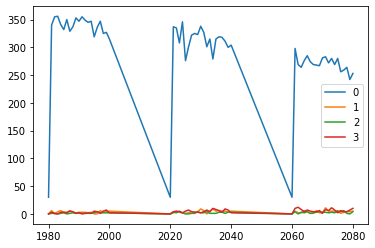

In [91]:
heatwave_df.plot()

<AxesSubplot:>

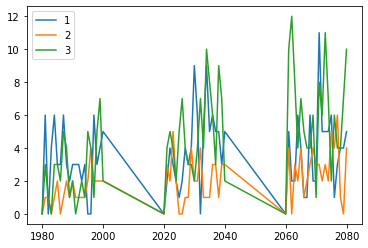

In [110]:
heatwave_df[[1,2,3]].plot()

<AxesSubplot:xlabel='index', ylabel='1'>

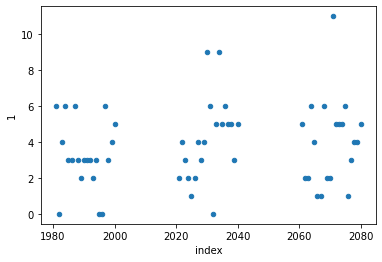

In [117]:
heatwave_df.drop(index=[1980, 2020, 2060]).reset_index().plot(x='index', y=1, kind='scatter')

## Can we use this function to plot "hot spells" for multiple ensembles?

In [18]:
def consec_count(data, threshold=25, ndays=14):
    
    days = np.arange(0, ndays+1)
    heatwave_counts = {}
    years = np.unique(data.year)
    for year in years:
        counts = np.zeros_like(days)
        arr = data[data.year==year]
        arr_hot = arr>threshold
        hots = np_consecutive(arr_hot)
        colds = np.count_nonzero(~arr_hot)
        counts[0]=colds
        for day in days[1:-1]:
            counts[day]=np.count_nonzero(hots==day)
        counts[-1]=np.count_nonzero(hots>=days[-1])

        heatwave_counts[year]=counts
    return heatwave_counts

In [19]:
hs_counts = consec_count(lon, 27, 3)
hs_df = pd.DataFrame.from_dict(hs_counts, orient='index')

In [20]:
hs_df

,0,1,2,3
1980,30,0,0,0
1981,350,4,3,0
1982,357,1,1,0
1983,360,0,0,0
1984,354,2,2,0
...,...,...,...,...
2076,279,2,1,6
2077,281,8,3,4
2078,281,0,2,6
2079,260,4,2,7


`consec_count()` cannot handle the dimensionality of the multi-ensemble cube, so we need to compensate

In [135]:
data = tasx
ensemble = np.unique(tasx.ensemble_member)
temp = 30
days = 2
dfs = []
for member in ensemble:
    arr = data.sel(ensemble_member=member).compute()
    counts = consec_count(arr, temp, days)
    df = pd.DataFrame.from_dict(counts, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'year'}, inplace=True)
    df['ensemble_member']=member
    dfs.append(df)

In [136]:
hs_dfs = pd.concat(dfs)

In [137]:
hs_dfs.head()

,year,0,1,2,ensemble_member
0,1980,30,0,0,1
1,1981,358,2,0,1
2,1982,360,0,0,1
3,1983,360,0,0,1
4,1984,360,0,0,1


<AxesSubplot:xlabel='year'>

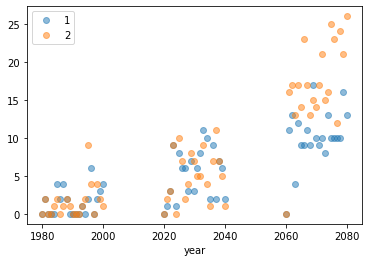

In [154]:
hs_dfs.groupby('year').sum().plot( y=[1,2], marker='o', alpha=0.5, ls="none")